In [1]:
# Define critical control variables

# Min/max values used to scale the height, lon, and lat
scale_minimum = 0
scale_maximum = 1

In [2]:
# Make the libraries directory searchable for Python imports
import sys
sys.path.insert(1, './libraries')

In [3]:
# Common imports
import os
from pathlib import Path

import numpy as np
import pandas as pd

from datetime import datetime

In [4]:
# Plotting
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

In [5]:
# Data pipeline, scaling, normalizing, etc
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer


In [6]:
# Import functions from the utilities file
from TZVOLCANO_utilities import *

# Early version of chords GUI interface
from chords_gui import chords_gui 

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


In [7]:
# Render the data download widget
domain = 'tzvolcano.chordsrt.com'
chords = chords_gui(domain)

# Define the initial start and end date for the date selector
start_date_string = '2021-01-01'
end_date_string = '2021-01-05'

# Generate the uer interface
chords.start_end_widgets(start_date_string, end_date_string)

Output()

In [8]:
chords.select_data_file()

Available Data Files


Output()

In [9]:
# Read contents of the selected file in to a pandas object
file_name = chords.available_data_files.value
print("Imported csv dat from" + file_name)

unmodified_data = chords.load_data_from_file(file_name)

Imported csv dat fromtzvolcano_chordsrt_com_instrument_id_1_2021-01-01_to_2021-01-01.csv
csv_files/tzvolcano_chordsrt_com_instrument_id_1_2021-01-01_to_2021-01-01.csv


In [10]:
# Fill in missing points in the time series
resampled_data = unmodified_data.copy()

resampled_data = resampled_data.set_index('Time').sort_index().resample('1000ms').ffill()

# Re-insert the 'Time' field, as the resampling process changed it to be the index
resampled_data['Time'] = resampled_data.index

# print(str(resampled_data['Time'].size - unmodified_data['Time'].size) + " missing points filled with NaN")

In [11]:
# Rescale Height, Longitude and Latitude to the range between scale_minimum and scale_maximum
scaled_data = pd.DataFrame()

# Convert the Time variable to Seconds Since Epoch
scaled_data["Seconds Since Epoch"] = resampled_data['Time'].astype(np.int64)
# scaled_data["Time"] = resampled_data['Time']

scaled_data["Scaled Height"] = scale_np_data(resampled_data["Height"].to_numpy(), scale_minimum, scale_maximum)
scaled_data["Scaled Latitude"] = scale_np_data(resampled_data["Latitude"].to_numpy(), scale_minimum, scale_maximum)
scaled_data["Scaled Longitude"] = scale_np_data(resampled_data["Longitude"].to_numpy(), scale_minimum, scale_maximum)

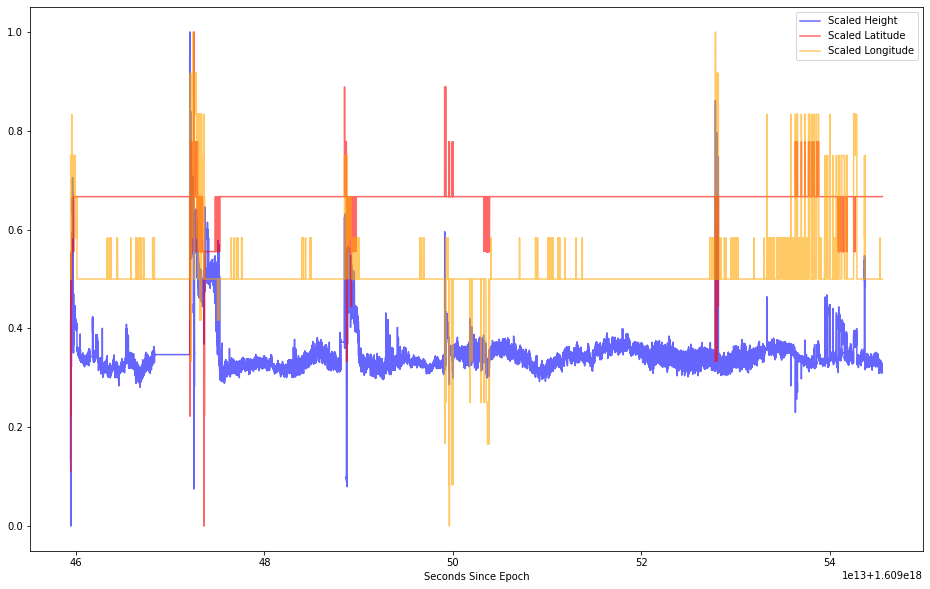

In [12]:
plt.figure(figsize=(16, 10))

# get current axis
ax = plt.gca()
alpha = 0.6

scaled_data.plot(kind='line',x='Seconds Since Epoch',y='Scaled Height', color='blue',ax=ax, alpha=alpha)
scaled_data.plot(kind='line',x='Seconds Since Epoch',y='Scaled Latitude', color='red', ax=ax, alpha=alpha)
scaled_data.plot(kind='line',x='Seconds Since Epoch',y='Scaled Longitude', color='orange', ax=ax, alpha=alpha)

plt.show()

In [13]:
# Treating the individual fields as a vector, calculate the scalar value as a derived feature
fields_list = ['Scaled Height', 'Scaled Latitude', 'Scaled Longitude']

scaled_data["Average Scalar"] = calculate_scalar(scaled_data, fields_list, scale_minimum, scale_maximum)

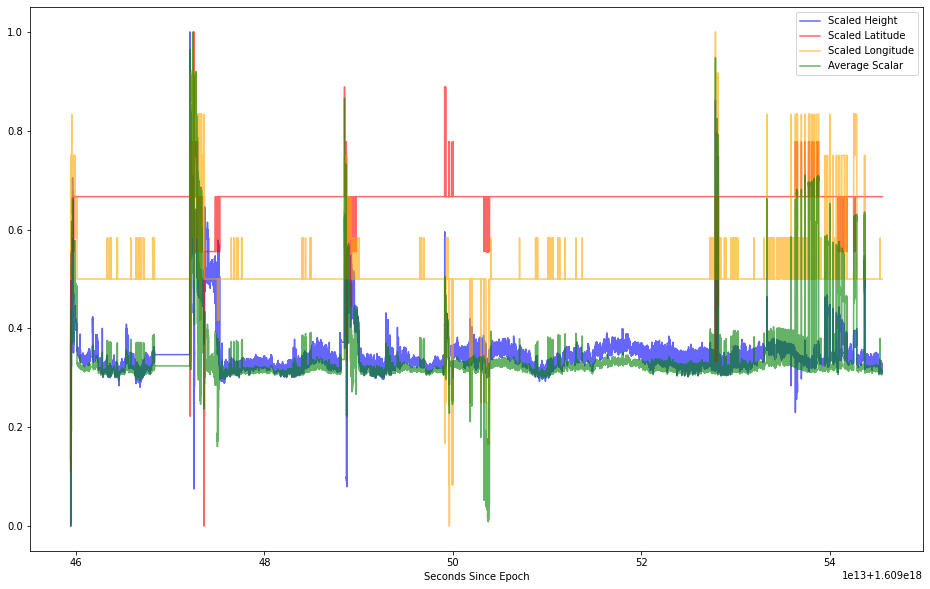

In [14]:
plt.figure(figsize=(16, 10))

# get current axis
ax = plt.gca()
alpha = 0.6

scaled_data.plot(kind='line',x='Seconds Since Epoch',y='Scaled Height', color='blue',ax=ax, alpha=alpha)
scaled_data.plot(kind='line',x='Seconds Since Epoch',y='Scaled Latitude', color='red', ax=ax, alpha=alpha)
scaled_data.plot(kind='line',x='Seconds Since Epoch',y='Scaled Longitude', color='orange', ax=ax, alpha=alpha)

scaled_data.plot(kind='line',x='Seconds Since Epoch',y='Average Scalar', color='green', ax=ax, alpha=alpha)

plt.show()

In [15]:
scalar_data = scaled_data.drop(["Scaled Longitude", "Scaled Latitude", "Scaled Height"], axis=1)

scalar_data.keys()

Index(['Seconds Since Epoch', 'Average Scalar'], dtype='object')

In [16]:
# Define a pipline to clean numerical data
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="most_frequent")),
])

# Test that the pipeline works
scalar_data_imputed = num_pipeline.fit_transform(scalar_data)

scalar_data_imputed

array([[1.60945943e+18, 0.00000000e+00],
       [1.60945943e+18, 8.06914679e-02],
       [1.60945944e+18, 8.11127876e-02],
       ...,
       [1.60954559e+18, 3.07886754e-01],
       [1.60954559e+18, 3.10037907e-01],
       [1.60954560e+18, 3.11396556e-01]])

<AxesSubplot:xlabel='Seconds Since Epoch', ylabel='Average Scalar'>

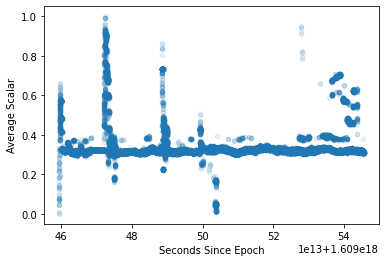

In [17]:
scalar_data.plot(kind="scatter", x="Seconds Since Epoch", y="Average Scalar", alpha=0.1)

In [18]:
from sklearn.mixture import GaussianMixture

In [19]:
N_COMPONENTS = 1
N_INIT = 10
COVARIANCE_TYPE = "tied"

gm = GaussianMixture(n_components=N_COMPONENTS, n_init=N_INIT,covariance_type=COVARIANCE_TYPE, random_state=42)
gm.fit(scalar_data_imputed)

GaussianMixture(covariance_type='tied', n_init=10, random_state=42)

In [20]:
gm.predict(scalar_data_imputed)

array([0, 0, 0, ..., 0, 0, 0])

In [21]:
gm.predict_proba(scalar_data_imputed)

array([[1.],
       [1.],
       [1.],
       ...,
       [1.],
       [1.],
       [1.]])

In [22]:
height_data_new, y_new = gm.sample(6)
height_data_new

array([[1.60949016e+18, 3.24709679e-01],
       [1.60948640e+18, 4.41028591e-01],
       [1.60950834e+18, 3.18122139e-01],
       [1.60946323e+18, 3.87950675e-01],
       [1.60951419e+18, 3.72557196e-01],
       [1.60951404e+18, 3.01942788e-01]])

In [23]:
gm.score_samples(scalar_data_imputed)

array([-42.90863153, -38.0743583 , -38.0525318 , ..., -31.59744923,
       -31.5861957 , -31.57959987])

In [24]:
resolution = 100
grid = np.arange(-10, 10, 1 / resolution)
xx, yy = np.meshgrid(grid, grid)
X_full = np.vstack([xx.ravel(), yy.ravel()]).T

pdf = np.exp(gm.score_samples(X_full))
pdf_probas = pdf * (1 / resolution) ** 2
pdf_probas.sum()

0.0

./libraries/TZVOLCANO_utilities.py:176: UserWarning: No contour levels were found within the data range.
  plt.contour(xx, yy, Z,


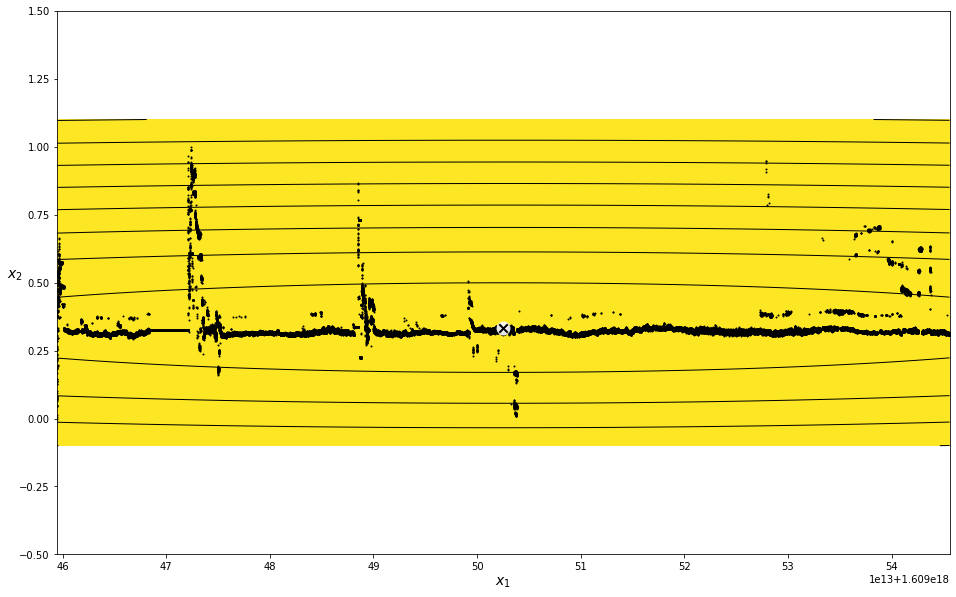

In [25]:
plt.figure(figsize=(16, 10))

plot_gaussian_mixture(gm, scalar_data_imputed)
plt.ylim(top=1.5, bottom= -0.5)
# save_fig("gaussian_mixtures_plot")
plt.show()

./libraries/TZVOLCANO_utilities.py:176: UserWarning: No contour levels were found within the data range.
  plt.contour(xx, yy, Z,


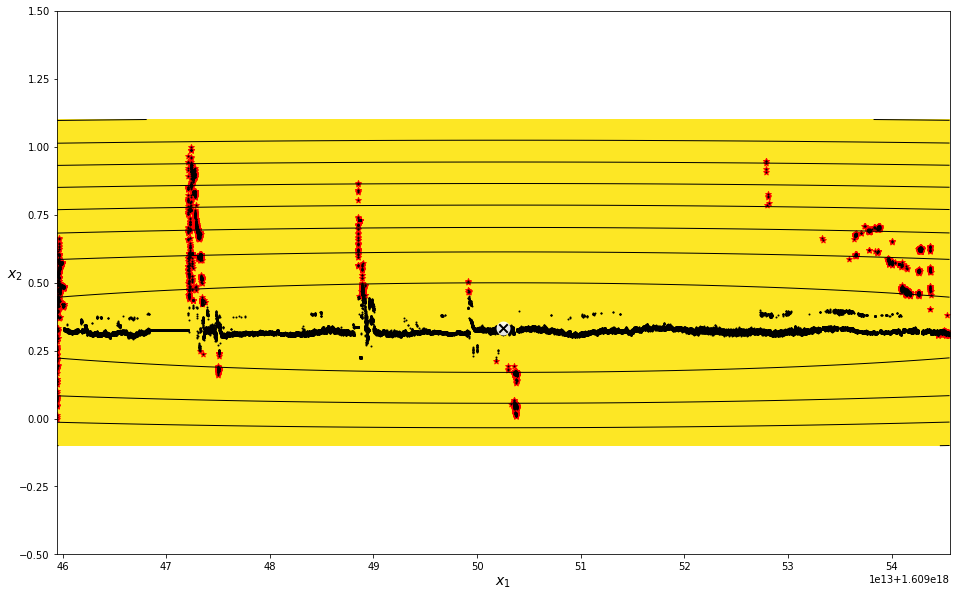

In [26]:
DENSITY_THRESHOLD_PERCENT = 6

densities = gm.score_samples(scalar_data_imputed)

density_threshold = np.percentile(densities, DENSITY_THRESHOLD_PERCENT)
anomalies = scalar_data_imputed[densities < density_threshold]



plt.figure(figsize=(16, 10))

plot_gaussian_mixture(gm, scalar_data_imputed)
plt.scatter(anomalies[:, 0], anomalies[:, 1], color='r', marker='*')
plt.ylim(top=1.5, bottom= -0.5)

# save_fig("mixture_anomaly_detection_plot")
plt.show()

In [27]:
anomalies

array([[1.60945943e+18, 0.00000000e+00],
       [1.60945943e+18, 8.06914679e-02],
       [1.60945944e+18, 8.11127876e-02],
       ...,
       [1.60954559e+18, 3.07886754e-01],
       [1.60954559e+18, 3.10037907e-01],
       [1.60954560e+18, 3.11396556e-01]])

In [28]:
# convert the list of anomalies to dateime data type so they can be used to filter the scaled data set
times_to_remove = pd.to_datetime(anomalies[:, 0], unit='ns', utc=True)

# remove the flagged times from the scaled data set 

cleaned_scaled_data = scaled_data.copy().drop(times_to_remove)
cleaned_scaled_data.keys()

Index(['Seconds Since Epoch', 'Scaled Height', 'Scaled Latitude',
       'Scaled Longitude', 'Average Scalar'],
      dtype='object')

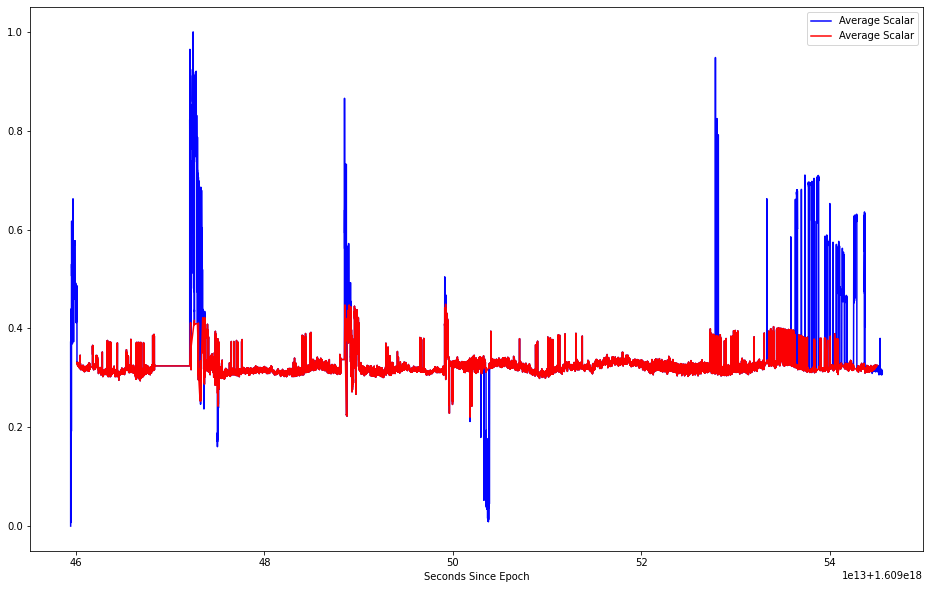

In [29]:
plt.figure(figsize=(16, 10))

# get current axis
ax = plt.gca()
alpha = 0.99

# cleaned_scaled_data.plot(x="Seconds Since Epoch", y="Scaled Height",figsize=(16, 10))


scaled_data.plot(kind='line',x='Seconds Since Epoch',y='Average Scalar', color='blue',ax=ax, alpha=alpha)
cleaned_scaled_data.plot(kind='line',x='Seconds Since Epoch',y='Average Scalar', color='red',ax=ax, alpha=alpha)

plt.show()